In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
import easyocr

In [2]:
#detecting license plate on the vehicle
plateCascade = cv2.CascadeClassifier('indian_license_plate.xml')

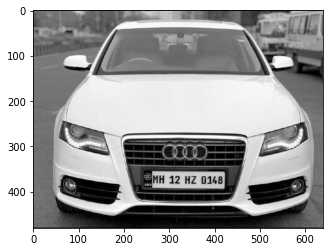

In [3]:
img = cv2.imread('mcar.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

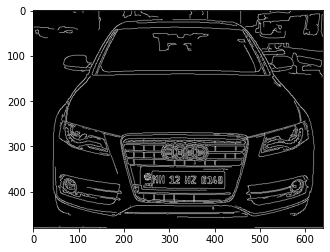

In [4]:
bfilter = cv2.bilateralFilter(gray, 11, 17, 17) #Noise reduction
edged = cv2.Canny(bfilter, 30, 200) #Edge detection
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

In [5]:
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

In [6]:
location = None
for contour in contours:
    approx = cv2.approxPolyDP(contour, 10, True)
    if len(approx) == 4:
        location = approx
        break

In [7]:
location

array([[[262, 356]],

       [[420, 355]],

       [[423, 389]],

       [[264, 391]]], dtype=int32)

In [8]:
mask = np.zeros(gray.shape, np.uint8)
new_image = cv2.drawContours(mask, [location], 0,255, -1)
new_image = cv2.bitwise_and(img, img, mask=mask)

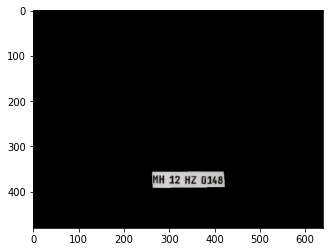

In [9]:
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

In [10]:
(x,y) = np.where(mask==255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
cropped_image = gray[x1:x2+1, y1:y2+1]

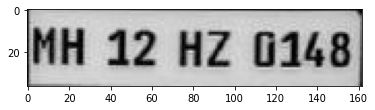

In [11]:
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

In [12]:
def find_contours(dimensions, img) :

    #finding all contours in the image using 
    #retrieval mode: RETR_TREE
    #contour approximation method: CHAIN_APPROX_SIMPLE
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    #Approx dimensions of the contours
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    #Check largest 15 contours for license plate character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ci = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        #detecting contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        #checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) 
            char_copy = np.zeros((44,24))
            #extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            cv2.rectangle(ci, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ci, cmap='gray')
            char = cv2.subtract(255, char)
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0
            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    #return characters on ascending order with respect to the x-coordinate
            
    plt.show()
    #arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [13]:
def segment_characters(image) :

    #pre-processing cropped image of plate
    #threshold: convert to pure b&w with sharpe edges
    #erod: increasing the backgroung black
    #dilate: increasing the char white
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    #estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    #getting contours
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

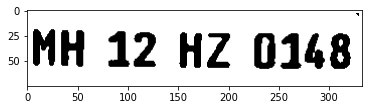

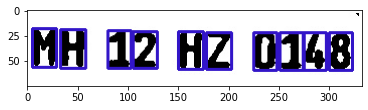

In [14]:
char = segment_characters(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

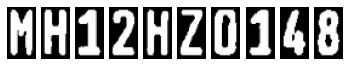

In [15]:
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')

In [16]:
import keras.backend as K
import tensorflow as tf
from sklearn.metrics import f1_score 
from keras import optimizers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
path = 'indian_licenseplate_recognition/data/data/'
train_generator = train_datagen.flow_from_directory(
        path+'/train',  
        target_size=(28,28), 
        batch_size=1,
        class_mode='sparse')

validation_generator = train_datagen.flow_from_directory(
        path+'/val',  
        target_size=(28,28),  
        class_mode='sparse')

Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


In [17]:
#It is the harmonic mean of precision and recall
#Output range is [0, 1]
#Works for both multi-class and multi-label classification
def f1score(y, y_pred):
    return f1_score(y, tf.math.argmax(y_pred, axis=1), average='micro') 

def custom_f1score(y, y_pred):
    return tf.py_function(f1score, (y, y_pred), tf.double)

In [18]:
K.clear_session()
model = Sequential()
model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0001), metrics=[custom_f1score])

c:\python37\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [19]:
class stop_training_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_custom_f1score') > 0.99):
            self.model.stop_training = True

In [20]:
batch_size = 1
callbacks = [stop_training_callback()]
model.fit_generator(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator, 
      epochs = 80, verbose=1, callbacks=callbacks)

c:\python37\lib\site-packages\keras\engine\training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/80
864/864 [==============================] - 46s 41ms/step - loss: 3.4603 - custom_f1score: 0.0787 - val_loss: 1.7909 - val_custom_f1score: 0.4658
Epoch 2/80
864/864 [==============================] - 40s 47ms/step - loss: 1.5772 - custom_f1score: 0.5378 - val_loss: 0.6347 - val_custom_f1score: 0.8214
Epoch 3/80
864/864 [==============================] - 36s 41ms/step - loss: 0.7508 - custom_f1score: 0.7720 - val_loss: 0.3518 - val_custom_f1score: 0.9167
Epoch 4/80
864/864 [==============================] - 36s 41ms/step - loss: 0.4344 - custom_f1score: 0.8762 - val_loss: 0.1899 - val_custom_f1score: 0.9286
Epoch 5/80
864/864 [==============================] - 36s 42ms/step - loss: 0.3348 - custom_f1score: 0.8859 - val_loss: 0.3921 - val_custom_f1score: 0.8616
Epoch 6/80
864/864 [==============================] - 36s 42ms/step - loss: 0.2291 - custom_f1score: 0.9252 - val_loss: 0.3484 - val_custom_f1score: 0.9077
Epoch 7/80
864/864 [==============================] - 36s 42ms/s

In [26]:
reader = easyocr.Reader(['en'])
result = reader.readtext(cropped_image)
result

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[0, 4], [162, 4], [162, 34], [0, 34]], 'MH 12 HZ 0148', 0.8178974409476597)]

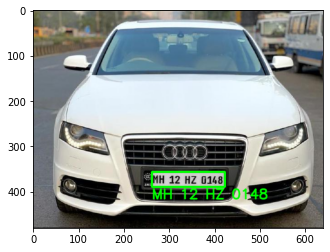

In [27]:
text = result[0][-2]
font = cv2.FONT_HERSHEY_SIMPLEX
res = cv2.putText(img, text=text, org=(approx[0][0][0], approx[1][0][1]+60), fontFace=font, fontScale=1, color=(0,255,0), thickness=2, lineType=cv2.LINE_AA)
res = cv2.rectangle(img, tuple(approx[0][0]), tuple(approx[2][0]), (0,255,0),3)
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))

In [28]:
text

'MH 12 HZ 0148'